In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import copy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.metrics import Recall
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Model
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def functional_model(HEIGHT, WIDTH, outdim):
    # Define the input layer
    inputs = Input(shape=(HEIGHT, WIDTH, 3))

    # 첫번째 conv+pooling layer
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 두번째 conv+pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # 세번째 conv+pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name = 'gradlayer')(x)

    
    x = Flatten()(x)

    # Dense layer with 512 units
    x = Dense(512)(x)
    x = Activation('relu')(x)

    # Output layer with softmax activation
    outputs = Dense(outdim, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [3]:
class project:
    def __init__(self, i, initial_path, HEIGHT, WIDTH, outdim, epochs):
        self.HEIGHT, self.WIDTH, self.outdim = HEIGHT, WIDTH, outdim
        self.model = functional_model(self.HEIGHT, self.WIDTH, self.outdim)
        self.i = i
        self.epochs = epochs
        self.initial_path = initial_path
        self.early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링할 지표 (여기서는 검증 손실)
                               patience=4,          # 지정된 횟수만큼 개선이 없을 경우 훈련 중단
                               restore_best_weights=True)
        # ImageDataGenerator 설정
        self.datagen1 = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.05,
            height_shift_range=0.05,
            brightness_range=[0.8, 1.1],
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest')
        self.datagen2 = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.05,
            height_shift_range=0.05,
            brightness_range=[0.9, 1.2],
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest')        
        # rotation 각도를 키우는 것이 주효함

    def data_loader(self, path, final_num, w1, w2, h1, h2, gen):
                # 이미지 파일 확장자 (여기서는 jpg, jpeg, png로 가정)
        valid_image_extensions = ['.jpg', '.jpeg', '.png']

        # 해당 경로의 이미지 파일 목록 가져오기
        image_files = [f for f in os.listdir(path) if os.path.splitext(f)[1].lower() in valid_image_extensions]

        # 이미지를 저장할 리스트
        image_list = []

        # 각 이미지 파일에 대해 반복
        for image_file in image_files:
            # 이미지 파일 경로
            image_path = os.path.join(path, image_file)

            # 이미지 불러오기 (OpenCV를 사용하여)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = image.astype('float32')
            
            image = image[w1:w2, h1:h2]
            image = cv2.resize(image, (self.WIDTH, self.HEIGHT))
            image_list.append(image) # cv2리스트

        # 이미지 리스트를 NumPy 배열로 변환하여 반환
            
        image_batch = copy.deepcopy(image_list)

        m = []
        for i in range(0, final_num):
            k = random.randint(0, len(image_batch)-1)
            m.append(k)

        image_batch_ = copy.deepcopy(image_batch)

        aug = []
        for i in m:
            img = image_batch_[i]
            img_augmented = gen.random_transform(img)
            aug.append(img_augmented)

        all = image_batch + aug
        return all, image_batch, aug
        # 'image_batch' : 원본 / 'aug' : 증강된 데이터 / 'all' : 순서대로 원본+증강 

    def data_encoder(self, final_num_seal, final_num_unsealed):
        all_fail, image_batch_fail, aug_fail = self.data_loader(os.path.join(self.initial_path, os.listdir(self.initial_path)[0]), final_num_seal, 50, 600, 200, 700, self.datagen2)
        all_pass, image_batch_pass, aug_pass = self.data_loader(os.path.join(self.initial_path, os.listdir(self.initial_path)[1]), final_num_unsealed, 240, 550, 300, 600, self.datagen2)
        # all_seal_np = np.array(all_seal)/255
        # all_unsealed_np = np.array(all_unsealed)/255
        # image_all = np.concatenate((all_seal_np, all_unsealed_np), axis=0)
        
        # array_1 = np.array([[1, 0]] * final_num_seal)
        # array_0 = np.array([[0, 1]] * final_num_unsealed)
        # label_all = np.concatenate((array_1, array_0), axis=0)
        aug_fail_np = np.array(aug_fail)/255
        aug_pass_np = np.array(aug_pass)/255
        image_all = np.concatenate((aug_fail_np, aug_pass_np), axis=0)
        
        array_1 = np.array([[1, 0]] * final_num_seal)
        array_0 = np.array([[0, 1]] * final_num_unsealed)
        label_all = np.concatenate((array_1, array_0), axis=0)
        # 데이터를 훈련 세트(80%)와 테스트 세트(20%)로 나누기
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(image_all, label_all, test_size=0.2, random_state=42)

        # 나머지 데이터를 검증 세트(25%)와 테스트 세트(75%)로 나누기
        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        
    def train(self):
        
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        epoch = self.epochs
        batch_size = 64

        # validation_data 매개변수를 사용하여 검증 세트를 지정
        self.History = self.model.fit(self.X_train, self.y_train, epochs=epoch,
                            batch_size=batch_size, shuffle=True,
                            validation_data=(self.X_valid, self.y_valid), 
                            callbacks=[self.early_stopping],
                            verbose=1).history

    def confusion_matrix(self):
        pass

    def gradcam(self, img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] 
        heatmap = tf.squeeze(heatmap)  # 축 쥐어짜서 (squeeze) 없애주기 ([높이, 너비, 1] -> [높이, 너비]가 됨)
        max_val = tf.math.reduce_max(heatmap)
        if max_val == 0:
            max_val = 1e-10  # 매우 작은 값을 사용하여 나누기 오류 방지
        heatmap = tf.maximum(heatmap, 0) / max_val
        return heatmap
    
    def subplot(self, n):

        heatmap = self.gradcam(self.X_test[n:n+1], self.model, 'gradlayer')

        # 가로로 두 개의 서브플롯 생성
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # 첫 번째 서브플롯에 그래프 그리기
        ax1.imshow(heatmap)
        ax1.set_title('heatmap')

        # 두 번째 서브플롯에 그래프 그리기
        ax2.imshow(self.X_test[n])
        ax2.set_title('Image')

        # 레이아웃 조정 및 그래프 표시
        plt.tight_layout()
        plt.show()
        #plt.savefig('subplot{}.png'.format(n))

    # loss plot graph. history의 훈련 과정에서 loss의 추세를 보여줌
    def loss_plot(self):
        plt.plot(self.History['loss'])
        plt.plot(self.History['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['train', 'vaild'])
        plt.yscale('log')
        plt.show()

In [4]:
# 객체 생성
initial_path = '../cleandata/(3)'
outdim = 2
PROJECT = project(2, initial_path, 256, 256, outdim, 10)
# 데이터를 불러오는 작업
PROJECT.data_encoder(1000, 1000)
PROJECT.train()

2023-12-16 19:44:26.028596: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 19:44:27.197796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-12-16 19:44:27.198853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22310 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2023-12-16 19:44:27.199688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0

Epoch 1/10


2023-12-16 19:44:58.223336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2023-12-16 19:44:58.833825: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 19:44:58.834976: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 19:44:58.834989: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-12-16 19:44:58.835950: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 19:44:58.835990: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-16 19:44:59.729489: I tensorflow/stream_executor/cuda/c

25/25 [==============================] - 4s 55ms/step - loss: 0.6353 - accuracy: 0.7225 - val_loss: 0.0751 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 1s 46ms/step - loss: 0.0233 - accuracy: 0.9981 - val_loss: 2.0621e-04 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 1s 45ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 1s 46ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 9.1528e-04 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 1s 46ms/step - loss: 4.7810e-04 - accuracy: 1.0000 - val_loss: 2.7704e-05 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 1s 47ms/step - loss: 2.4239e-05 - accuracy: 1.0000 - val_loss: 2.4506e-06 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 1s 46ms/step - loss: 8.8439e-06 - accuracy: 1.0000 - val_loss: 1.5852e-06 - val_accuracy:

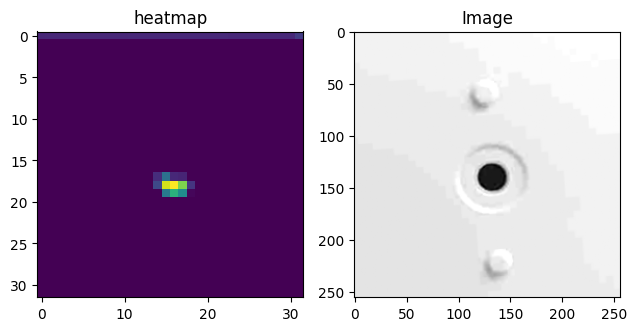

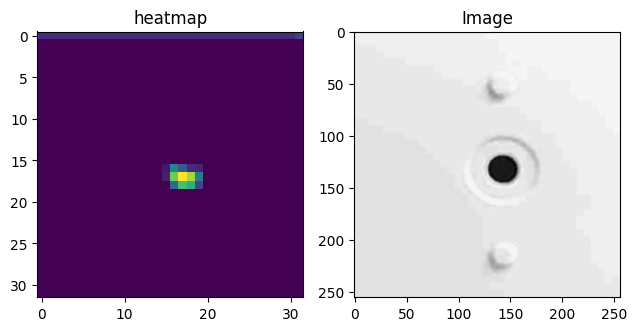

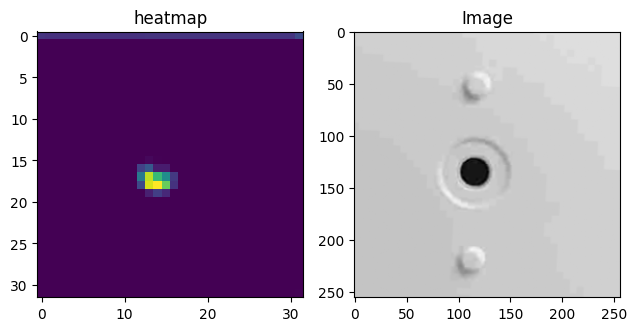

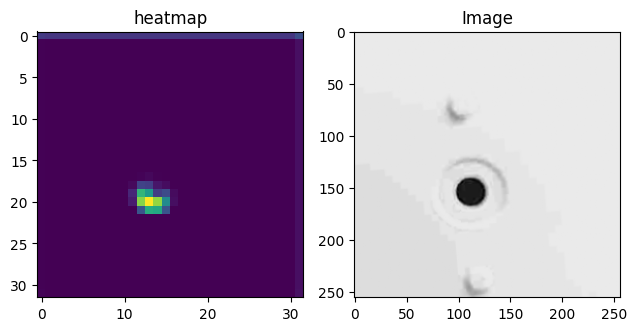

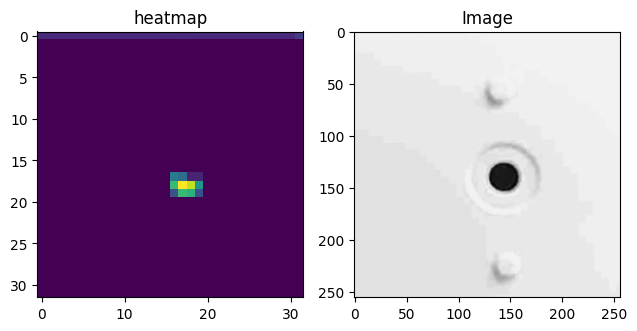

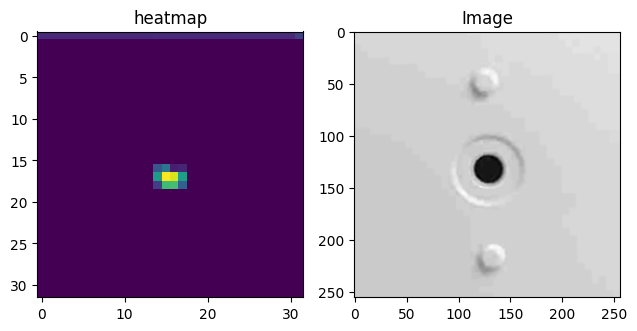

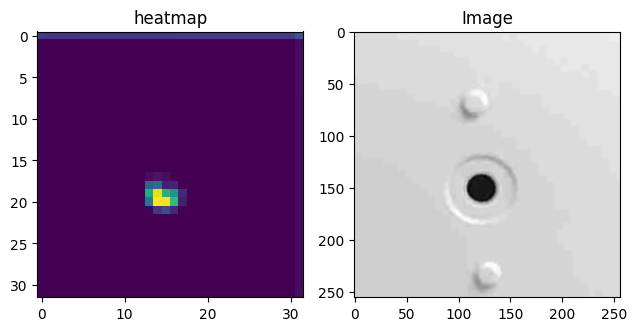

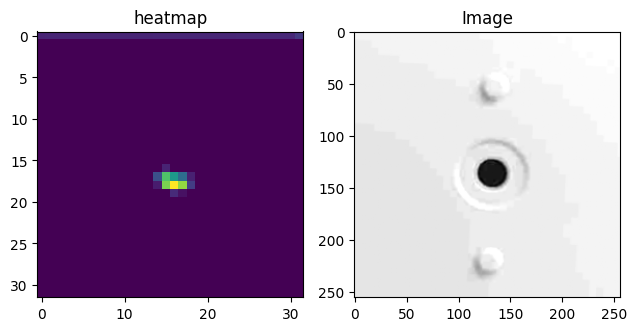

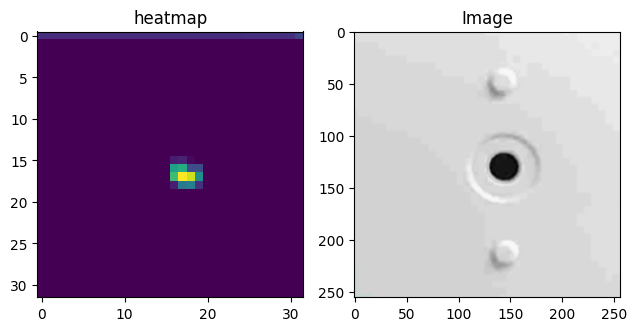

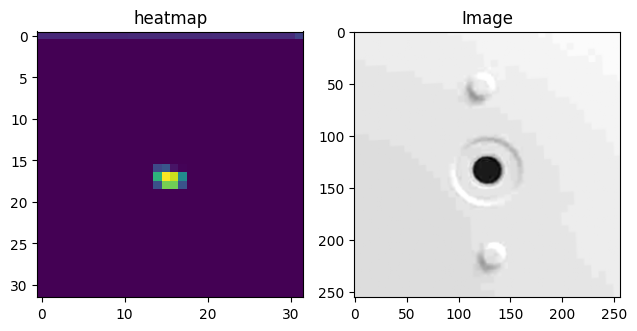

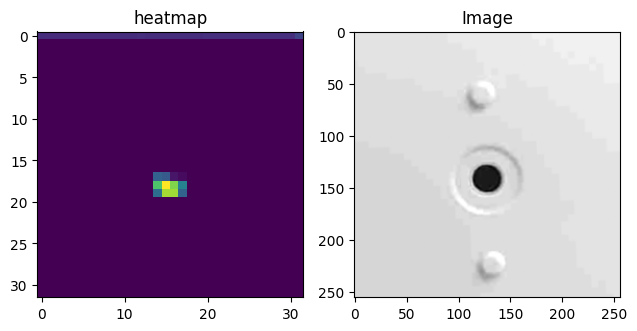

In [5]:
indices = np.where(PROJECT.y_test[:, 1] == 1)[0]
n=0
for index in indices:
    PROJECT.subplot(index)
    n=n+1
    if n>10:
        break

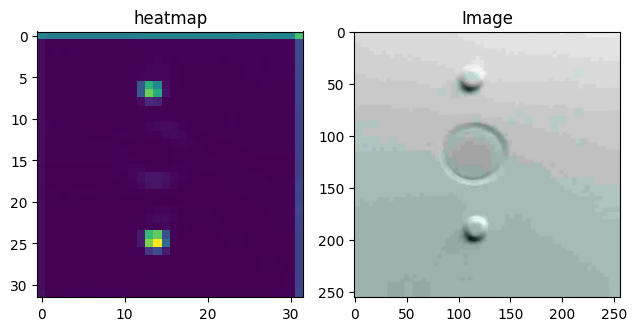

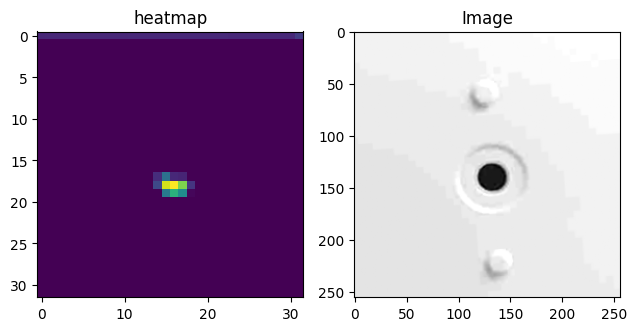

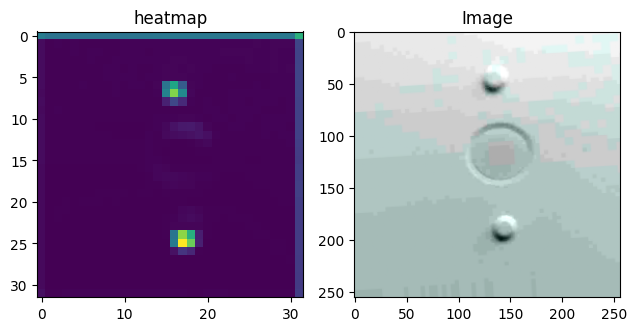

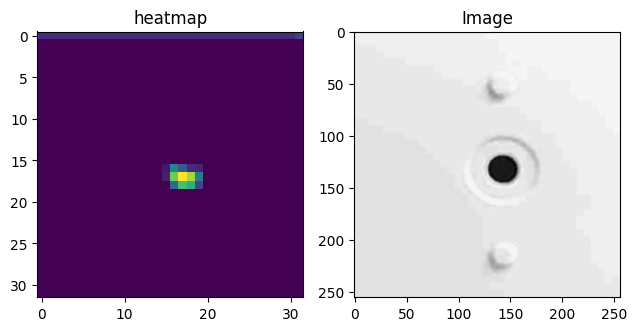

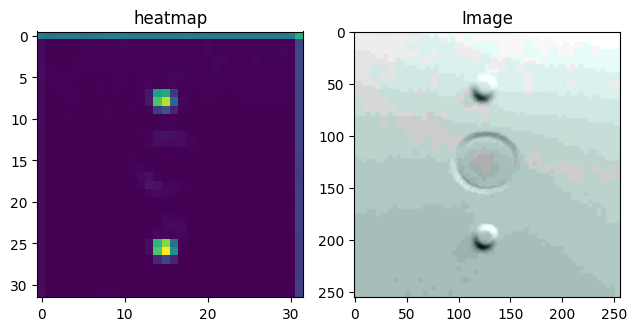

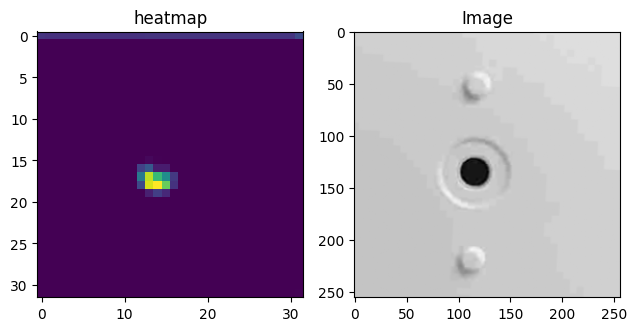

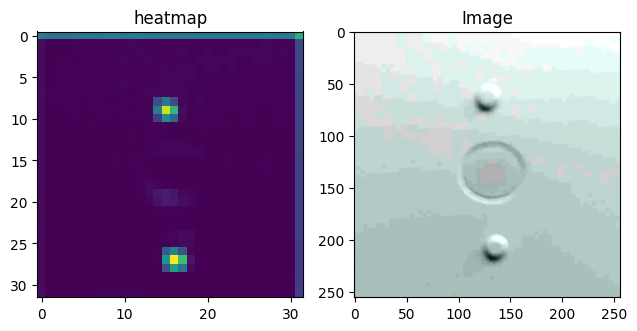

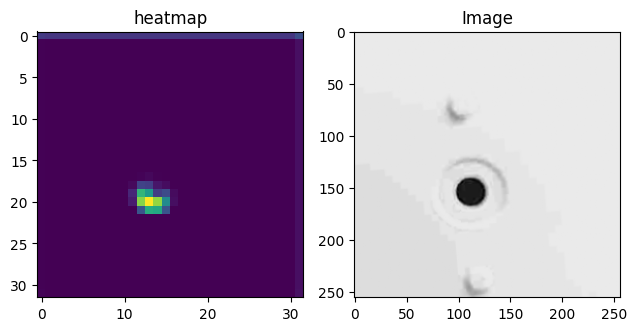

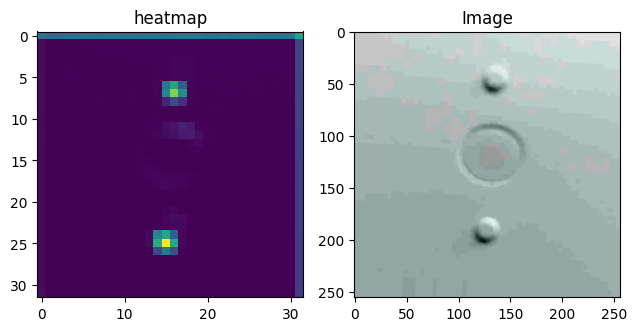

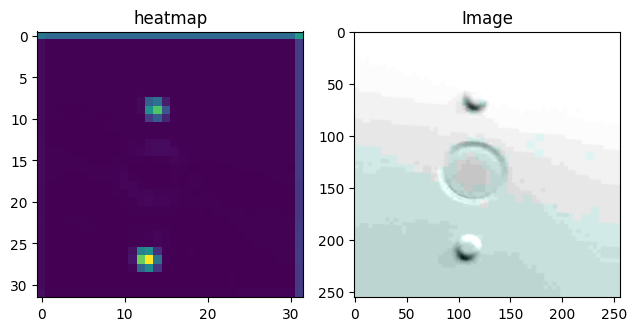

In [6]:
for i in range(10):
    PROJECT.subplot(i)